## Testing snapping a stroke based on 2 anchor points:
Given a stroke with a starting and ending spot, it may be useful to adjust the bounding box so that the start/end point is adjusted to two other points (e.g. to connect to 2 other stroke start/end points.

Consider a given stroke with the bound defined by two points $p_0$ and $p_1$ with the stroke start beginning at $s$ and ending at $e$. Now suppose we want to stretch and translate the strokes bounding box so the stroke starting and ending points are mapped to $a$ and $b$, respectively.

We need to figure out a $n_0$ and $n_1$ to be the new points defining the bounding box. Let $n_0 = p_0 + d_0$ and $n_1 = p_1 + d_1$

</br>

Solution:

Construct $f_s = \frac{\left(s-p_{0}\right)}{p_{1}-p_{0}}$ which is the fractional distance $s$ is within the bounding box. Construct $f_e$ similarly.

We know $s = (1-f_s)p_0 + f_s p_1$, similarly for $e$. Likewise $a = (1-f_s)(p_0 + d_0) + f_s(p_1 + d_1)$, similarly for $b$.

After some manipulation we find $a-s = (1-f_s)d_0 + f_s d_1$ and $(a-s)-f_s d_1)/(1-f_s) = d_0 = (b-e)-f_e d_1)/(1-f_e)$.

Yada yada yada, more algebra we get $d_1 = \frac{(1-f_e)(s-a)+(1-f_s)(b-e)}{f_e-f_s}$ Note this formula is undefined if we have two points which have the same $y$ or $x$ coordinates.

Also $d_0=\frac{(a-s)-f_s d_1}{1-f_s} = \frac{(b-e)-f_e d_1}{1-f_e}$.

['C0', 'C1', 'C4', 'D0', 'D1']
[2.49 0.97] [0.97 2.  ]
[1.83 1.03]


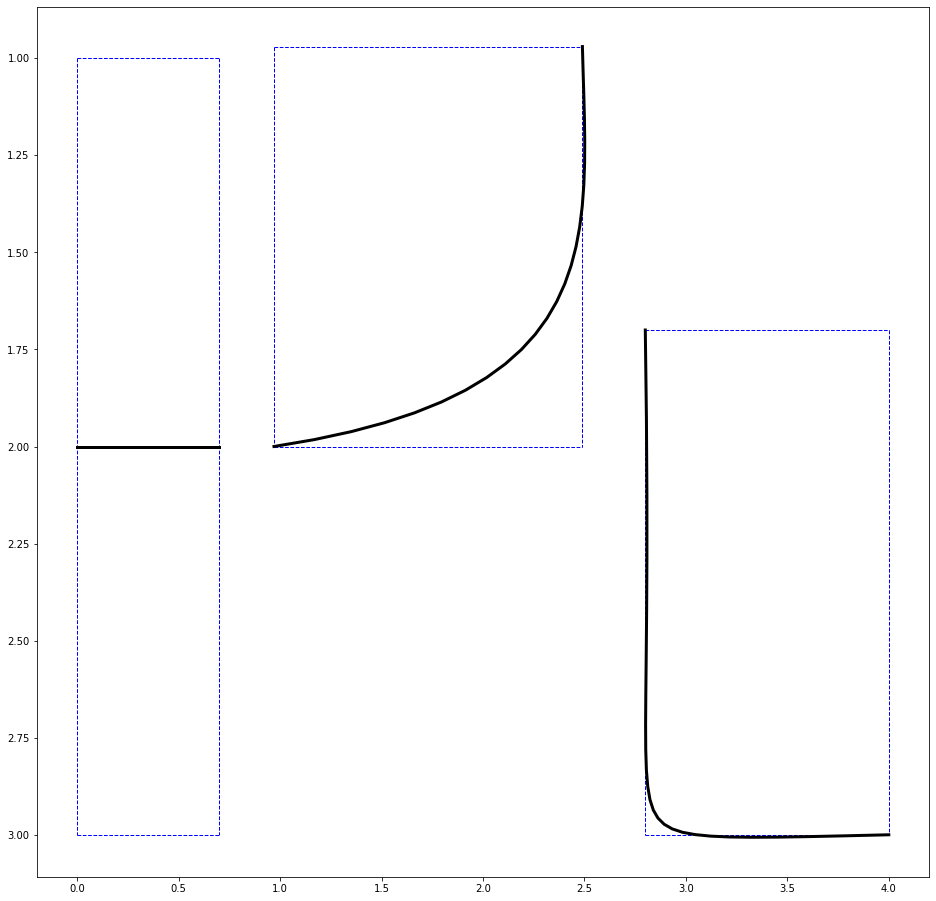

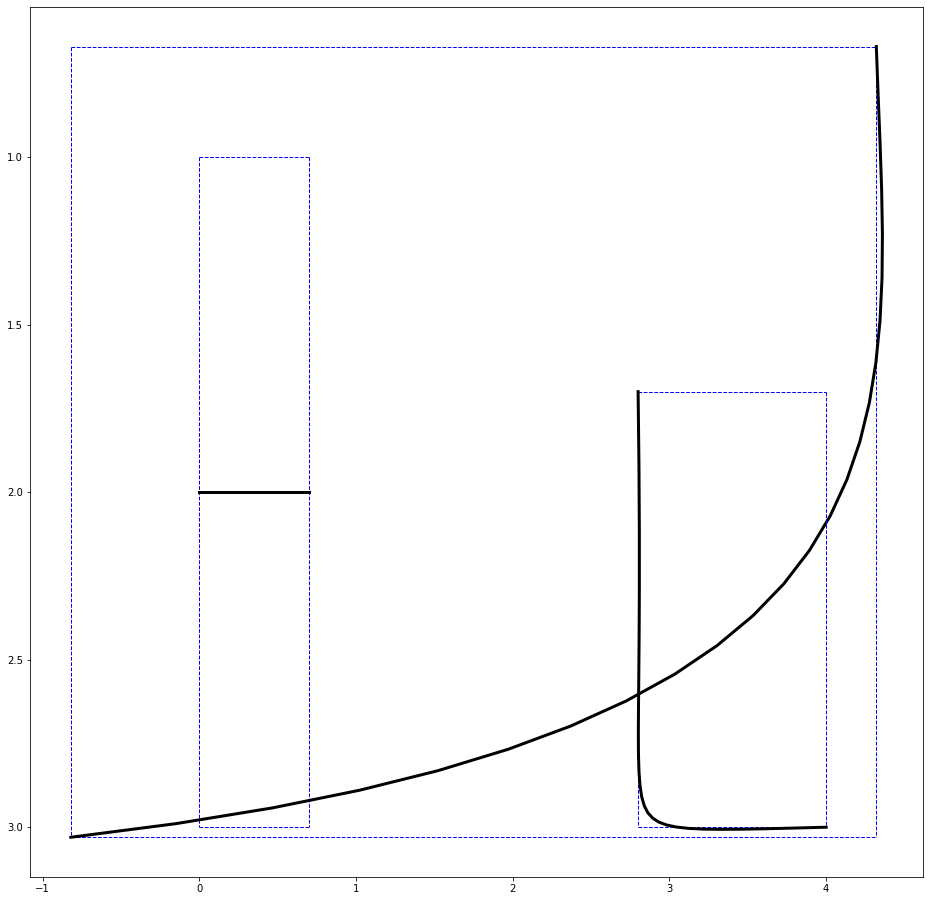

In [65]:
import numpy as np
#back end libraries for loading/saving/modifying our data
import StrokeFit as sf
from FitDef import FitData
import FitDef as fd
from StrokeDef import StrokeType #needed for loading object properly
import StrokeDef as sd
import matplotlib.pyplot as plt
import bezier

strokes = sd.loadStrokeDict()
strokeNames = list(strokes.keys())
print(strokeNames)

fit1 = sf.Fit(strokeNames[3], [0,.7], [1,3])
fit2 = sf.Fit(strokeNames[1], [.97,2.49], [.97, 2])
fit3 = sf.Fit(strokeNames[2], [2.8,4], [1.7,3])

fits = FitData()
fits.set("0", [fit1,fit2,fit3], [1000,1000])

figFit, axFit = graphFits(strokes, [fit1,fit2,fit3])

strokeData1 = strokes[fit1.name].arial
strokeData2 = strokes[fit2.name].arial
strokeData3 = strokes[fit3.name].arial

mapStart = np.array(strokeData1[-1][-1]) #end of this stroke
mapEnd = np.array(strokeData3[0][0]) #start of this stroke
#need actual coordinates of these things tho, so adjust
mapStart = mapCoord(fit1, mapStart)
mapEnd = mapCoord(fit3, mapEnd)
#print(mapStart, mapEnd)

mappedFit = adjustFit(fit2, strokeData2, mapStart, mapEnd)
fig2Fit, ax2Fit = graphFits(strokes, [fit1,mappedFit,fit3])

In [64]:
def graphFits(strokeDefs, fits, resol=25):
    fig, ax = plt.subplots(figsize=(16,16))
    ax.invert_yaxis()

    evalPoints = np.linspace(0.0, 1.0, resol) #determines how accurate bezier curves are drawn
    for fit in fits: #plot bounding box and bezier curves
        arr2 = np.ones(2) # just [1,1], makes these next lines a bit more readable
        ax.plot( fit.x[0]*arr2, fit.y, linestyle="dashed", color="blue", linewidth=1) #plot bounding box
        ax.plot( fit.x[1]*arr2, fit.y, linestyle="dashed", color="blue", linewidth=1)
        ax.plot( fit.x, fit.y[0]*arr2, linestyle="dashed", color="blue", linewidth=1)
        ax.plot( fit.x, fit.y[1]*arr2, linestyle="dashed", color="blue", linewidth=1)
        
        for curve in sf.mapStroke(strokeDefs[fit.name].hanzi, fit.x, fit.y): #control points, 
            nodes = np.array(curve).transpose()
            curve = bezier.Curve(nodes, degree=len(curve)-1)
            curvePoints = np.array(curve.evaluate_multi(evalPoints).transpose().tolist()) #[[x,y]...]
            ax.plot(curvePoints[:,0], curvePoints[:,1], color="black", linewidth=3)
    return fig, ax

def mapCoord(fit, coord):
    temp = np.zeros((2))
    temp[0] = (1-coord[0])*fit.x[0] + coord[0]*fit.x[1]
    temp[1] = (1-coord[1])*fit.y[0] + coord[1]*fit.y[1]
    return temp

def adjustFit(fit, strokeData, newS, newE, tol=.001):
    p0 = np.array([fit.x[0], fit.y[0]])
    p1 = np.array([fit.x[1], fit.y[1]])
    
    fs = np.array(strokeData[0][0])
    fe = np.array(strokeData[-1][-1])
    
    s = (1-fs)*p0 + fs*p1
    e = (1-fe)*p0 + fe*p1
    
    print(s,e)
    
    d0 = np.zeros((2))
    d1 = np.zeros((2))
    
    if(abs(fs[0]-fe[0]) >= tol): #check for divide by zero
        d1[0] = ((1-fe[0])*(s[0] - newS[0]) + (1-fs[0])*(newE[0] - e[0]))/(fe[0]-fs[0]) #WHY IS THIS NEGATIVE NEEDED
    if(abs(fs[1]-fe[1]) >= tol): #check for divide by zero
        d1[1] = ((1-fe[1])*(s[1] - newS[1]) + (1-fs[1])*(newE[1] - e[1]))/(fe[1]-fs[1])
    
    if(abs(1-fs[0]) >= tol):
        d0[0] = ((newS[0] - s[0]) - fs[0]*d1[0]) / (1-fs[0])
    elif(abs(1-fe[0]) >= tol):
        d0[0] = ((newE[0] - e[0]) - fe[0]*d1[0]) / (1-fe[0])
        
    if(abs(1-fs[1]) >= tol):
        d0[1] = ((newS[1] - s[1]) - fs[1]*d1[1]) / (1-fs[1])
    elif(abs(1-fe[1]) >= tol):
        d0[1] = ((newE[1] - e[1]) - fe[1]*d1[1]) / (1-fe[1])
    #d1 = ((1-fe)*(newS - s) + (1-fs)*(newE - e))/(fe-fs)
    #d0 = ((newS - s) - fs*d1) / (1-fs)
    newP0 = p0+d0
    newP1 = p1+d1
    return sf.Fit(fit.name, [newP0[0], newP1[0]], [newP0[1], newP1[1]])
    #if(not np.any(np.isclose(fs, fe, atol=.001))): #x or y coordinates don't match
    #    return fit #return as is for now
        #find closest point and only map to that one
    

In [94]:
x = np.array([0,0])
x[0] = 1
print(x[0],x)

1 [1 0]
